#  Predict Future Sales

## Import data sets

In [1]:
import numpy as np
import pandas as pd

### import data

train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv').set_index('ID')
items  = pd.read_csv("items.csv")
cats = pd.read_csv('item_categories.csv')

train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [2]:
# a = train.item_id
# b = test.item_id
# #a = item_id_train.sort_values()
# #b = item_id_test.sort_values()
# res = b.isin(pd.to_numeric(a, errors='coerce')).all()
# print(res)

# # a_list = a.tolist()
# # b_list = b.tolist()
# # main_list = [item for item in b_list if item not in a_list]

# c = set(b) - set(b).intersection(set(a))
# print(len(list(c)))
# print(len(set(b)))
# print(len(set(a)))

## Data Preprocessing

### Drop Duplicates

In [3]:
train.drop_duplicates(keep='first', inplace=True)
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


According to the result, 6 duplicates were found and dropped.

### Outlier Detection

In [4]:
### Detect outliers with z-score and remove them

def detect_outliers(outliers, data):
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    outliers_index = train.loc[(data < (-3 * std + mean)) | (data > (3 * std + mean))].index.tolist()
    for i in data:
        z_score = (i - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers, outliers_index


train_sales_outliers = []
train_price_outliers = []
train_sales = train.item_cnt_day
train_price = train.item_price

train_sales_outliers, outliers_index = detect_outliers(train_sales_outliers, train_sales)
train = train.drop(outliers_index, axis=0)

train_price_outliers, outliers_index = detect_outliers(train_price_outliers, train_price)
train = train.drop(outliers_index, axis=0)

result = "The training sales outliers are {}".format(np.array(train_sales_outliers))
print(result)
result = "The training prices outliers are {}".format(np.array(train_price_outliers))
print(result)
result = "The size of the cleaned training data is {}".format(np.array(train).size)
print(result)


### locate and remove the items with the price lower than zero, and fill with median value

print(train.loc[train_price < 0, 'item_price'])
print(train.loc[484680:484685,:])
shop_id = int(train.loc[train_price < 0, 'shop_id'])
item_id = int(train.loc[train_price < 0, 'item_id'])
date_block_num = int(train.loc[train_price < 0, 'date_block_num'])
result = "One negative price detected: Shop_id: {}, item_id: {}, date_block_num: {}".format(shop_id, item_id,
                                                                                            date_block_num)
print(result)
median = train[(train.shop_id == shop_id) & (train.item_id == item_id) & (train.date_block_num == date_block_num) & (
        train.item_price > 0)].item_price.median()
train.loc[train_price < 0, 'item_price'] = median

The training sales outliers are [13. 13. 10. ... 15. 10. 35.]
The training prices outliers are [ 8490.  6190. 13499. ...  7990.  7990.  9990.]
The size of the cleaned training data is 17372358
484683   -1.0
Name: item_price, dtype: float64
              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484680  18.05.2013               4       32     3046       799.0           1.0
484681  07.05.2013               4       32     3017       299.0           1.0
484682  23.05.2013               4       32     2973      1249.0           1.0
484683  15.05.2013               4       32     2973        -1.0           1.0
484684  06.05.2013               4       32     2973      2499.0           1.0
484685  02.05.2013               4       32     2972       599.0           1.0
One negative price detected: Shop_id: 32, item_id: 2973, date_block_num: 4


### Substitue 'date' column with 'month' column in the train data set

In [5]:
import datetime
def DateMonth(time):
    day,month,year = time.split('.')
    return int(month)
train['month']=list(map(DateMonth,train['date']))

In [6]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
0,02.01.2013,0,59,22154,999.00,1.0,1
1,03.01.2013,0,25,2552,899.00,1.0,1
2,05.01.2013,0,25,2552,899.00,-1.0,1
3,06.01.2013,0,25,2554,1709.05,1.0,1
4,15.01.2013,0,25,2555,1099.00,1.0,1
...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,10
2935845,09.10.2015,33,25,7460,299.00,1.0,10
2935846,14.10.2015,33,25,7459,349.00,1.0,10
2935847,22.10.2015,33,25,7440,299.00,1.0,10


### Add up day sales into month sales

In [7]:
train = train.drop('date',axis=1).groupby(["item_id","shop_id","date_block_num"]).agg({'item_price':'mean','month':'mean','item_cnt_day':'sum'}).reset_index()
train.rename(columns = {"item_cnt_day":"item_cnt_month"},inplace=True)
train

,item_id,shop_id,date_block_num,item_price,month,item_cnt_month
0,0,54,20,58.0,9,1.0
1,1,55,15,4490.0,4,2.0
2,1,55,18,4490.0,7,1.0
3,1,55,19,4490.0,8,1.0
4,1,55,20,4490.0,9,1.0
...,...,...,...,...,...,...
1594190,22168,12,8,799.0,9,1.0
1594191,22168,16,1,799.0,2,1.0
1594192,22168,42,1,799.0,2,1.0
1594193,22168,43,2,798.5,3,1.0


### Add seasonality into train data set

Let's look into the correlation between sales and month to check whether seasonality needs to be considered.

In [8]:
import matplotlib.pyplot as plt
target = train[['date_block_num', 'item_cnt_month']].groupby(["date_block_num"]).sum().reset_index()
plt.figure(figsize=(10, 6))
plt.title('Total Sales of Item')
plt.xlabel('Month Block')
plt.ylabel('Sales of Item')
plt.plot(target['date_block_num'], target['item_cnt_month'])

We can see that there are clear rise and fall of sales of item with different month, so it is beneficial to consider seasonality into account.

In [9]:
train['season']=1
train['season'][(train['month']>=2) & (train['month']<=4)]=1
train['season'][(train['month']>=5) & (train['month']<=7)]=2
train['season'][(train['month']>=8) & (train['month']<=10)]=3
train['season'][(train['month']==11) | (train['month']==12) | (train['month']==1)]=4

C:\Users\YOOJI\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\YOOJI\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YOOJI\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the 

In [10]:
train

,item_id,shop_id,date_block_num,item_price,month,item_cnt_month,season
0,0,54,20,58.0,9,1.0,3
1,1,55,15,4490.0,4,2.0,1
2,1,55,18,4490.0,7,1.0,2
3,1,55,19,4490.0,8,1.0,3
4,1,55,20,4490.0,9,1.0,3
...,...,...,...,...,...,...,...
1594190,22168,12,8,799.0,9,1.0,3
1594191,22168,16,1,799.0,2,1.0,1
1594192,22168,42,1,799.0,2,1.0,1
1594193,22168,43,2,798.5,3,1.0,1


### Add time variables into train data set

In [11]:
for i in range(1,6):
    train['T'+str(i)] = train['item_cnt_month'].shift(i)
train.fillna(0,inplace=True)

In [12]:
train

,item_id,shop_id,date_block_num,item_price,month,item_cnt_month,season,T1,T2,T3,T4,T5
0,0,54,20,58.0,9,1.0,3,0.0,0.0,0.0,0.0,0.0
1,1,55,15,4490.0,4,2.0,1,1.0,0.0,0.0,0.0,0.0
2,1,55,18,4490.0,7,1.0,2,2.0,1.0,0.0,0.0,0.0
3,1,55,19,4490.0,8,1.0,3,1.0,2.0,1.0,0.0,0.0
4,1,55,20,4490.0,9,1.0,3,1.0,1.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1594190,22168,12,8,799.0,9,1.0,3,1.0,1.0,1.0,2.0,1.0
1594191,22168,16,1,799.0,2,1.0,1,1.0,1.0,1.0,1.0,2.0
1594192,22168,42,1,799.0,2,1.0,1,1.0,1.0,1.0,1.0,1.0
1594193,22168,43,2,798.5,3,1.0,1,1.0,1.0,1.0,1.0,1.0


### Add item category into train data set

In [13]:
#cats = items.iloc[:,1:]
#train = pd.merge(train, cats, how='left', on='item_id')
#print(train.head())
df_category = pd.merge(items,cats,on=['item_category_id'])
df_category

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD
...,...,...,...,...
22165,Элемент питания GP 15AU (LR6) - Блистер 2 шт U...,22095,83,Элементы питания
22166,Элемент питания GP 24A (LR03) - Блистер 2 шт,22096,83,Элементы питания
22167,Элемент питания GP 24AU (LR03) - Блистер 2 шт ...,22097,83,Элементы питания
22168,Элемент питания КОСМОС LR03 2*BL,22098,83,Элементы питания


In [14]:
df_category['item_category_id'].astype(np.int32)
df_category['new_item_category'] = 'other'
df_category['new_item_category'][df_category['item_category_id'].between(1,8,inclusive=True)] = 'Digital Appliances'
df_category['new_item_category'][df_category['item_category_id'].between(10,18,inclusive=True)] = 'Consoles'
df_category['new_item_category'][df_category['item_category_id'].between(18,25,inclusive=True)] = 'Consoles Games'
df_category['new_item_category'][df_category['item_category_id'].between(26,27,inclusive=True)] = 'Phone games'
df_category['new_item_category'][df_category['item_category_id'].between(28,31,inclusive=True)] = 'CD games'
df_category['new_item_category'][df_category['item_category_id'].between(32,36,inclusive=True)] = 'Card'
df_category['new_item_category'][df_category['item_category_id'].between(37,42,inclusive=True)] = 'Movie'
df_category['new_item_category'][df_category['item_category_id'].between(43,54,inclusive=True)] = 'Books'
df_category['new_item_category'][df_category['item_category_id'].between(55,60,inclusive=True)] = 'Music'
df_category['new_item_category'][df_category['item_category_id'].between(61,72,inclusive=True)] = 'Gifts'
df_category['new_item_category'][df_category['item_category_id'].between(73,79,inclusive=True)] = 'Soft'

C:\Users\YOOJI\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\YOOJI\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\YOOJI\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [15]:
train = pd.merge(train,df_category[['item_id','new_item_category']],on=['item_id'],how='left')

In [16]:
train

,item_id,shop_id,date_block_num,item_price,month,item_cnt_month,season,T1,T2,T3,T4,T5,new_item_category
0,0,54,20,58.0,9,1.0,3,0.0,0.0,0.0,0.0,0.0,Movie
1,1,55,15,4490.0,4,2.0,1,1.0,0.0,0.0,0.0,0.0,Soft
2,1,55,18,4490.0,7,1.0,2,2.0,1.0,0.0,0.0,0.0,Soft
3,1,55,19,4490.0,8,1.0,3,1.0,2.0,1.0,0.0,0.0,Soft
4,1,55,20,4490.0,9,1.0,3,1.0,1.0,2.0,1.0,0.0,Soft
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594190,22168,12,8,799.0,9,1.0,3,1.0,1.0,1.0,2.0,1.0,Gifts
1594191,22168,16,1,799.0,2,1.0,1,1.0,1.0,1.0,1.0,2.0,Gifts
1594192,22168,42,1,799.0,2,1.0,1,1.0,1.0,1.0,1.0,1.0,Gifts
1594193,22168,43,2,798.5,3,1.0,1,1.0,1.0,1.0,1.0,1.0,Gifts


In [17]:
df_cate = pd.get_dummies(train['new_item_category'],drop_first=True)
df_season = pd.get_dummies(train['season'], drop_first=True)
train = pd.concat([train,df_cate,df_season],axis=1)
train.drop(['new_item_category','season'], axis=1, inplace=True)
train.drop('month', axis=1, inplace=True)
train

,item_id,shop_id,date_block_num,item_price,item_cnt_month,T1,T2,T3,T4,T5,...,Digital Appliances,Gifts,Movie,Music,Phone games,Soft,other,2,3,4
0,0,54,20,58.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
1,1,55,15,4490.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,1,55,18,4490.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0,0
3,1,55,19,4490.0,1.0,1.0,2.0,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,0
4,1,55,20,4490.0,1.0,1.0,1.0,2.0,1.0,0.0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594190,22168,12,8,799.0,1.0,1.0,1.0,1.0,2.0,1.0,...,0,1,0,0,0,0,0,0,1,0
1594191,22168,16,1,799.0,1.0,1.0,1.0,1.0,1.0,2.0,...,0,1,0,0,0,0,0,0,0,0
1594192,22168,42,1,799.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,1,0,0,0,0,0,0,0,0
1594193,22168,43,2,798.5,1.0,1.0,1.0,1.0,1.0,1.0,...,0,1,0,0,0,0,0,0,0,0


## Apply LSTM model

In [18]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(15, input_shape=(1,23)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15)                2340      
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 2,356
Trainable params: 2,356
Non-trainable params: 0
_________________________________________________________________


### For item_id  is 2445 and shop_id is 25

In order to apply the LSTM model to predict future sales, there is an issue with computational complexity. Since we have to apply the model to each item in different store, there are hundreds of different items needs to be applied the model. The comments in the next block is my idea of applying the model to the whole data set, but according to the computational issue, it took too long. Therefore, I decided to only look into a few item to see the model's performance. Following is the result of the item_id 2445 with the shop_id 25:

In [20]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# for i in train['item_id']:
#     for j in train[train['item_id'] == i]['shop_id']:
#         df = train[(train['item_id'] == i) & (train['shop_id'] == j)]
        
#         ### Create the dataframe with full months
#         month_list = [k for k in range(34)]
#         shop_list = []
#         for k in range(34):
#             shop_list.append(j)
#         item_list = []
#         for k in range(34):
#             item_list.append(i)
#         add_month = pd.DataFrame({'date_block_num':month_list, 'item_id':item_list, 'shop_id':shop_list})
        
#         ### Create the new df with every single month
#         df = pd.merge(train, add_month, how = 'right', on = ['item_id', 'shop_id','date_block_num'])
#         df = df.sort_values(by = ['date_block_num'])
#         df.fillna(0.00, inplace = True)
#         columns = df.columns
#         df = df[columns].reset_index()
#         df = df.drop(labels = ['index'], axis = 1)
          
#         ### Split the train and validation set
#         train_df = df[df['date_block_num']<=30]
#         val_df = df[df['date_block_num']>30]
#         x_train,y_train = train_df.drop(["item_cnt_month"],axis=1),train_df.item_cnt_month
#         x_val,y_val = val_df.drop(["item_cnt_month"],axis=1),val_df.item_cnt_month
        
#         # Reshape the data between -1 and 1 and to 3D
#         scaler = MinMaxScaler(feature_range=(-1, 1))
#         x_train[['item_price']] = scaler.fit_transform(x_train[['item_price']])
#         x_val[['item_price']] = scaler.fit_transform(x_val[['item_price']])
#         x_train_scaled = x_train.to_numpy()
#         x_valid_scaled = x_val.to_numpy()
#         x_train_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
#         x_val_reshaped = x_valid_scaled.reshape((x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1]))
#         history = model_lstm.fit(x_train_reshaped, y_train, validation_data=(x_val_reshaped, y_val),epochs=70, batch_size=64, verbose=2, shuffle=False)
#         y_pre = model_lstm.predict(x_val_reshaped)
        
        
#         from sklearn.metrics import mean_squared_error
#         from numpy import sqrt
#         rmse = sqrt(mean_squared_error(y_val,y_pre))
#         print('Val RMSE: %.3f' % rmse)
        

,item_id,shop_id,date_block_num,item_price,item_cnt_month,T1,T2,T3,T4,T5,...,Digital Appliances,Gifts,Movie,Music,Phone games,Soft,other,2,3,4
151910,2445,25,1,1199.000000,18.0,3.0,3.0,5.0,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
151911,2445,25,2,1198.943182,45.0,18.0,3.0,3.0,5.0,1.0,...,0,0,0,0,0,0,0,0,0,0
151912,2445,25,3,636.492188,30.0,45.0,18.0,3.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0
151913,2445,25,4,1079.000000,6.0,30.0,45.0,18.0,3.0,3.0,...,0,0,0,0,0,0,0,1,0,0
151914,2445,25,5,599.000000,13.0,6.0,30.0,45.0,18.0,3.0,...,0,0,0,0,0,0,0,1,0,0
151915,2445,25,6,599.000000,19.0,13.0,6.0,30.0,45.0,18.0,...,0,0,0,0,0,0,0,1,0,0
151916,2445,25,7,460.888889,12.0,19.0,13.0,6.0,30.0,45.0,...,0,0,0,0,0,0,0,0,1,0
151917,2445,25,8,349.416667,9.0,12.0,19.0,13.0,6.0,30.0,...,0,0,0,0,0,0,0,0,1,0
151918,2445,25,9,599.000000,9.0,9.0,12.0,19.0,13.0,6.0,...,0,0,0,0,0,0,0,0,1,0
151919,2445,25,10,599.000000,5.0,9.0,9.0,12.0,19.0,13.0,...,0,0,0,0,0,0,0,0,0,1


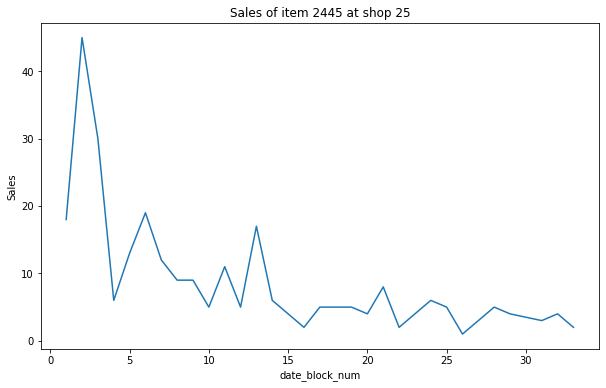

In [31]:
import matplotlib.pyplot as plt

df = train[(train['item_id'] == 2445) & (train['shop_id'] == 25)]

plt.figure(figsize=(10,6))
plt.title('Sales of item 2445 at shop 25')
plt.xlabel('date_block_num')
plt.ylabel('Sales')
plt.plot()
df = train[(train['item_id'] == 2445) & (train['shop_id'] == 25)]
plt.plot(df['date_block_num'],df['item_cnt_month'])
df

In [22]:
month_list = [i for i in range(34)]
shop_list = []
for i in range(34):
    shop_list.append(25)
item_list = []
for i in range(34):
    item_list.append(2445)
add_month = pd.DataFrame({'date_block_num':month_list, 'item_id':item_list, 'shop_id':shop_list})
add_month

,date_block_num,item_id,shop_id
0,0,2445,25
1,1,2445,25
2,2,2445,25
3,3,2445,25
4,4,2445,25
5,5,2445,25
6,6,2445,25
7,7,2445,25
8,8,2445,25
9,9,2445,25


In [23]:
df = pd.merge(train, add_month, how = 'right', on = ['item_id', 'shop_id','date_block_num'])
df = df.sort_values(by = ['date_block_num'])
df.fillna(0.00, inplace = True)
columns = df.columns
df = df[columns].reset_index()
df = df.drop(labels = ['index'], axis = 1)
df

,item_id,shop_id,date_block_num,item_price,item_cnt_month,T1,T2,T3,T4,T5,...,Digital Appliances,Gifts,Movie,Music,Phone games,Soft,other,2,3,4
0,2445,25,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2445,25,1,1199.000000,18.0,3.0,3.0,5.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2445,25,2,1198.943182,45.0,18.0,3.0,3.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2445,25,3,636.492188,30.0,45.0,18.0,3.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2445,25,4,1079.000000,6.0,30.0,45.0,18.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,2445,25,5,599.000000,13.0,6.0,30.0,45.0,18.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,2445,25,6,599.000000,19.0,13.0,6.0,30.0,45.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,2445,25,7,460.888889,12.0,19.0,13.0,6.0,30.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,2445,25,8,349.416667,9.0,12.0,19.0,13.0,6.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,2445,25,9,599.000000,9.0,9.0,12.0,19.0,13.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
df.columns

Index([           'item_id',            'shop_id',     'date_block_num',
               'item_price',     'item_cnt_month',                 'T1',
                       'T2',                 'T3',                 'T4',
                       'T5',           'CD games',               'Card',
                 'Consoles',     'Consoles Games', 'Digital Appliances',
                    'Gifts',              'Movie',              'Music',
              'Phone games',               'Soft',              'other',
                          2,                    3,                    4],
      dtype='object')

In [25]:
train_df = df[df['date_block_num']<=30]
val_df = df[df['date_block_num']>30]
x_train,y_train = train_df.drop(['item_cnt_month'],axis=1),train_df.item_cnt_month
x_val,y_val = val_df.drop(['item_cnt_month'],axis=1),val_df.item_cnt_month

In [34]:
train_columns_scale = train.columns[5:]

In [27]:
# Reshape the data between -1 and 1 and to 3D
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_val)

x_train_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
x_val_reshaped = x_valid_scaled.reshape((x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1]))

In [28]:
history = model_lstm.fit(x_train_reshaped, y_train, validation_data=(x_val_reshaped, y_val),epochs=70, batch_size=12, verbose=2, shuffle=False)
y_pre = model_lstm.predict(x_val_reshaped)

Epoch 1/70
3/3 - 0s - loss: 154.5081 - accuracy: 0.0968 - val_loss: 8.3354 - val_accuracy: 0.0000e+00
Epoch 2/70
3/3 - 0s - loss: 153.3435 - accuracy: 0.0968 - val_loss: 8.0782 - val_accuracy: 0.0000e+00
Epoch 3/70
3/3 - 0s - loss: 152.2431 - accuracy: 0.0968 - val_loss: 7.8254 - val_accuracy: 0.0000e+00
Epoch 4/70
3/3 - 0s - loss: 151.1473 - accuracy: 0.0968 - val_loss: 7.5743 - val_accuracy: 0.0000e+00
Epoch 5/70
3/3 - 0s - loss: 150.0458 - accuracy: 0.1290 - val_loss: 7.3231 - val_accuracy: 0.0000e+00
Epoch 6/70
3/3 - 0s - loss: 148.9332 - accuracy: 0.0968 - val_loss: 7.0704 - val_accuracy: 0.0000e+00
Epoch 7/70
3/3 - 0s - loss: 147.8065 - accuracy: 0.0323 - val_loss: 6.8153 - val_accuracy: 0.0000e+00
Epoch 8/70
3/3 - 0s - loss: 146.6634 - accuracy: 0.0323 - val_loss: 6.5575 - val_accuracy: 0.0000e+00
Epoch 9/70
3/3 - 0s - loss: 145.5028 - accuracy: 0.0323 - val_loss: 6.2966 - val_accuracy: 0.0000e+00
Epoch 10/70
3/3 - 0s - loss: 144.3244 - accuracy: 0.0323 - val_loss: 6.0331 - val_

In [29]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_val,y_pre))
print('Val RMSE: %.3f' % rmse)

Val RMSE: 1.195


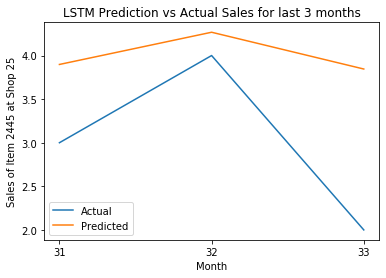

In [30]:
fig, ax = plt.subplots()
ax.plot(x_val['date_block_num'], y_val, label='Actual')
ax.plot(x_val['date_block_num'], y_pre, label='Predicted')
plt.title('LSTM Prediction vs Actual Sales for last 3 months')
plt.xlabel('Month')
plt.xticks(x_val['date_block_num'])
plt.ylabel('Sales of Item 2445 at Shop 25')
ax.legend()
plt.show()